In [205]:
import numpy as np
import pandas as pd

In [206]:
csv_path = '../results/human_evaluation_results.csv'  # UPDATE THIS PATH if necessary
item_col = 'hash'  # Unique identifier for the code review instance
rater_col = 'evaluator_id'  # Identifier for the human evaluator

# Rating Columns and Mappings
clarity_col = 'answer_2'
actionability_col = 'answer_1'
relevance_col = 'answer_3'
rating_cols = [clarity_col, actionability_col, relevance_col]
rating_names = ['Clarity', 'Actionability', 'Relevance']

NUM_EVALUATORS_EXPECTED = 5


# Mappings (ensure comprehensive handling of potential inputs)
def create_mapping(map_dict):
    base_map = map_dict.copy()
    # Handle potential empty strings or other non-rating values explicitly if needed
    base_map[''] = np.nan
    base_map[np.nan] = np.nan
    # Add other potential non-mappings if necessary
    # base_map['some_other_value'] = np.nan
    return base_map


clarity_mapping = create_mapping({
    'Not Clear': 1, 'Slightly Clear': 2, 'Moderately Clear': 3, 'Mostly Clear': 4, 'Very Clear': 5
})
actionability_mapping = create_mapping({
    'Not Actionable': 1, 'Slightly Actionable': 2, 'Moderately Actionable': 3, 'Mostly Actionable': 4,
    'Clearly Actionable': 5
})
relevance_mapping = create_mapping({
    'No Relevance': 1, 'Slightly Relevant': 2, 'Moderately Relevant': 3, 'Mostly Relevant': 4, 'Very Relevant': 5
})
mappings = {
    clarity_col: clarity_mapping,
    actionability_col: actionability_mapping,
    relevance_col: relevance_mapping,
}

In [207]:
df = pd.read_csv(csv_path)
print(f"Successfully loaded data from {csv_path}")

Successfully loaded data from ../results/human_evaluation_results.csv


In [208]:
numeric_rating_cols = []
numeric_rating_names = []
for col, name in zip(rating_cols, rating_names):
    if col in df.columns:
        print(f"Mapping column '{col}' ({name})...")
        numeric_col_name = f"{name}_numeric"
        # Ensure the original column is treated as string, fill NaNs before mapping
        df[col] = df[col].astype(str).fillna('')
        df[numeric_col_name] = df[col].map(mappings.get(col, {}))  # Use .get for safety

        # Check mapping quality
        unmapped_mask = df[numeric_col_name].isnull() & (df[col] != '') & (df[col] != 'nan')
        original_count = len(df)
        mapped_count = df[numeric_col_name].notnull().sum()
        unmapped_count = unmapped_mask.sum()

        if unmapped_count > 0:
            unmapped_values = df.loc[unmapped_mask, col].unique()
            print(
                f"  Warning: Found {unmapped_count} potentially unmapped string(s) in '{col}'. "
                f"Check mapping for: {list(unmapped_values)}. "
                f"Total mapped: {mapped_count}/{original_count}.")
        elif mapped_count > 0:
            print(f"  Successfully mapped {mapped_count}/{original_count} entries.")
        else:
            print(f"  No entries could be mapped in '{col}'.")

        numeric_rating_cols.append(numeric_col_name)
        numeric_rating_names.append(name)
    else:
        print(f"Warning: Rating column '{col}' not found in DataFrame. Skipping.")

print(f"\nNumeric columns created: {numeric_rating_cols}")


Mapping column 'answer_2' (Clarity)...
  Successfully mapped 540/540 entries.
Mapping column 'answer_1' (Actionability)...
  Successfully mapped 540/540 entries.
Mapping column 'answer_3' (Relevance)...
  Successfully mapped 540/540 entries.

Numeric columns created: ['Clarity_numeric', 'Actionability_numeric', 'Relevance_numeric']


In [209]:
df.head()

,evaluator_id,evaluator_uuid,spot_taken,id,uuid,dev_experience,review_giving_experience,review_receiving_experience,review_expertise,date_started,...,bert_quality,bert_score,prediction,summary,answer_1,answer_2,answer_3,Clarity_numeric,Actionability_numeric,Relevance_numeric
0,2,c36ff46f-9c77-4835-9150-885d90157805,True,2,c36ff46f-9c77-4835-9150-885d90157805,5-10,5-10,5-10,Advanced,2025-04-17 09:38:08.799+00,...,low,0.829126,The logger instance should be static and use t...,Package private for unit testing. All of the m...,Mostly Actionable,Very Clear,Very Relevant,5.0,4.0,5.0
1,1,e0113331-b577-40d5-b942-ec66e0190f0c,True,1,e0113331-b577-40d5-b942-ec66e0190f0c,5-10,3-5,1-3,Intermediate,2025-04-18 21:57:03.053+00,...,low,0.835138,Is there a real implementation change that cau...,Suspends the component with the given name. Cr...,Moderately Actionable,Very Clear,Very Relevant,5.0,3.0,5.0
2,5,c9c4d637-0417-4202-98b5-e7316b44eabc,True,5,c9c4d637-0417-4202-98b5-e7316b44eabc,3-5,3-5,3-5,Expert,2025-04-18 06:43:20.103+00,...,low,0.812043,Consider using an enum instead of string const...,Configuration for Azkaban. MUST BE BECAREFUL.,Mostly Actionable,Very Clear,Very Relevant,5.0,4.0,5.0
3,1,e0113331-b577-40d5-b942-ec66e0190f0c,True,1,e0113331-b577-40d5-b942-ec66e0190f0c,5-10,3-5,1-3,Intermediate,2025-04-18 21:57:03.053+00,...,high,0.902909,"The method description says it ""returns that"" ...",PutTLFCryptKeyServerHalves stores a set of use...,Moderately Actionable,Very Clear,Very Relevant,5.0,3.0,5.0
4,3,87d60415-2f53-42a3-afe5-21ca31f4c194,True,3,87d60415-2f53-42a3-afe5-21ca31f4c194,5-10,5-10,5-10,Expert,2025-04-18 15:11:58.054+00,...,medium,0.845522,This appears to be unnecessarily exposing inte...,Sets the scorer.,Clearly Actionable,Very Clear,Very Relevant,5.0,5.0,5.0


In [213]:
from matplotlib import pyplot as plt
import seaborn as sns

print("\n--- Descriptive Statistics (Based on Numeric Mapped Values) ---")
stats_df = df[numeric_rating_cols].agg(['mean', 'std', 'min', 'max', 'count']).round(3)
print(stats_df)

print("\n--- Frequency Distributions (Based on Numeric Mapped Values) ---")
rating_value_map = {1: '1 (Very Low)', 2: '2 (Low)', 3: '3 (Medium)', 4: '4 (High)', 5: '5 (Very High)'}
order = sorted([int(k) for k in rating_value_map.keys()])  # Ensure order is based on numeric keys
order_labels = [rating_value_map.get(i, str(i)) for i in order]

for col, name in zip(numeric_rating_cols, numeric_rating_names):
    print(f"\n--- {name} ({col}) ---")
    valid_ratings = df[col].dropna()
    if valid_ratings.empty:
        print("  No valid numeric ratings found for this column.")
        continue

    counts = valid_ratings.value_counts().sort_index()
    percentages = valid_ratings.value_counts(normalize=True).sort_index() * 100

    freq_df = pd.DataFrame({'Count': counts, 'Percentage': percentages.round(2)}).reindex(order).fillna(0)
    freq_df['Count'] = freq_df['Count'].astype(int)

    freq_df = freq_df.rename(index=rating_value_map)
    freq_df.index.name = 'Rating Value'
    print(freq_df)

    # plt.figure(figsize=(6, 4))
    # sns.countplot(x=df[col].dropna().astype(int), order=order)
    # plt.title(f'Distribution of {name} Ratings')
    # plt.xlabel("Rating")
    # plt.ylabel("Frequency")
    # plt.xticks(ticks=range(len(order_labels)), labels=order_labels, rotation=45, ha='right')
    # plt.tight_layout()
    # plt.show()


--- Descriptive Statistics (Based on Numeric Mapped Values) ---
       Clarity_numeric  Actionability_numeric  Relevance_numeric
mean               5.0                  4.378              4.998
std                0.0                  0.637              0.043
min                5.0                  2.000              4.000
max                5.0                  5.000              5.000
count            540.0                540.000            540.000

--- Frequency Distributions (Based on Numeric Mapped Values) ---

--- Clarity (Clarity_numeric) ---
               Count  Percentage
Rating Value                    
1 (Very Low)       0         0.0
2 (Low)            0         0.0
3 (Medium)         0         0.0
4 (High)           0         0.0
5 (Very High)    540       100.0

--- Actionability (Actionability_numeric) ---
               Count  Percentage
Rating Value                    
1 (Very Low)       0        0.00
2 (Low)            1        0.19
3 (Medium)        43        7.96
4

In [211]:
import krippendorff

# Identify overlap items
rater_counts_per_item = df.groupby(item_col)[rater_col].nunique()
overlap_items = rater_counts_per_item[rater_counts_per_item == NUM_EVALUATORS_EXPECTED].index
print(f"Found {len(overlap_items)} items rated by all {NUM_EVALUATORS_EXPECTED} evaluators (overlap set).")

if len(overlap_items) < 2:  # Need at least 2 items for Alpha
    print("Cannot calculate Alpha: Need at least 2 items rated by all expected evaluators.")
else:
    df_overlap = df[df[item_col].isin(overlap_items)].copy()
    alpha_results = {}
    for name in rating_names:
        numeric_col = f"{name}_numeric"
        if numeric_col not in df_overlap.columns:
            print(f"Skipping Alpha for '{name}': Numeric column '{numeric_col}' not found.")
            continue

        print(f"\nCalculating Alpha for: {name} ({numeric_col})")
        irr_data_long = df_overlap[[item_col, rater_col, numeric_col]]

        try:
            # Pivot requires unique index/column pairs for each item
            # Ensure uniqueness
            irr_data_long = irr_data_long.drop_duplicates(subset=[item_col, rater_col], keep='last')

            reliability_matrix_df = irr_data_long.pivot(index=item_col, columns=rater_col, values=numeric_col)
        except ValueError as e:
            print(f"  Error pivoting data for {name}: {e}. Check for residual duplicates.")
            alpha_results[name] = np.nan
            continue
        except Exception as e:
            print(f"  Unexpected error during pivot for {name}: {e}")
            alpha_results[name] = np.nan
            continue

        if reliability_matrix_df.shape[0] < 2 or reliability_matrix_df.shape[1] < 2:
            print(
                f"  Skipping Alpha for '{name}': Insufficient data after pivot (items={reliability_matrix_df.shape[0]}, raters={reliability_matrix_df.shape[1]}).")
            alpha_results[name] = np.nan
            continue

        reliability_data_list = reliability_matrix_df.values.tolist()

        unique_values = reliability_matrix_df.stack().dropna().unique()
        if len(unique_values) <= 1:
            print(
                f"  Skipping Alpha for '{name}': Zero variance in ratings (all valid ratings are '{unique_values[0]}').")
            alpha_results[name] = np.nan  # Or 1.0 if definitionally perfect agreement
            continue

        try:
            alpha_val = krippendorff.alpha(reliability_data=reliability_data_list,
                                           level_of_measurement='ordinal')
            alpha_results[name] = alpha_val
            print(f"  Krippendorff's Alpha (Ordinal) for {name}: {alpha_val:.3f}")
        except Exception as e:
            print(f"  Error calculating Alpha for {name} with krippendorff library: {e}")
            alpha_results[name] = np.nan

Found 60 items rated by all 5 evaluators (overlap set).

Calculating Alpha for: Clarity (Clarity_numeric)
  Skipping Alpha for 'Clarity': Zero variance in ratings (all valid ratings are '5.0').

Calculating Alpha for: Actionability (Actionability_numeric)
  Krippendorff's Alpha (Ordinal) for Actionability: 0.358

Calculating Alpha for: Relevance (Relevance_numeric)
  Skipping Alpha for 'Relevance': Zero variance in ratings (all valid ratings are '5.0').


  Skipping 'Clarity' from dimension correlation: Zero variance or column issue.

Calculating Spearman correlation between dimensions: ['Actionability_numeric', 'Relevance_numeric']

Spearman Correlation Matrix between Rating Dimensions:
                       Actionability_numeric  Relevance_numeric
Actionability_numeric                  1.000              0.083
Relevance_numeric                      0.083              1.000


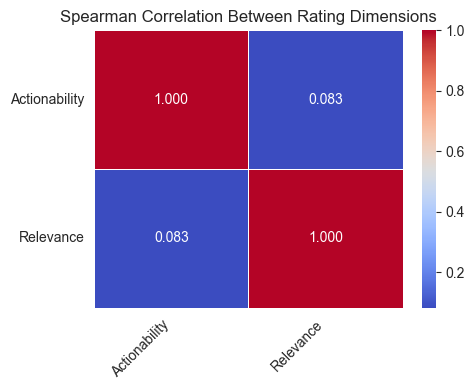

In [212]:
if len(numeric_rating_cols) < 2:
    print("Cannot calculate dimension correlation: Need at least two dimensions with valid data.")
else:
    cols_for_corr = []
    for col in numeric_rating_cols:
        if col in df.columns and df[col].dropna().nunique() > 1:
            cols_for_corr.append(col)
        else:
            print(
                f"  Skipping '{col.replace('_numeric', '')}' from dimension correlation: Zero variance or column issue.")

    if len(cols_for_corr) < 2:
        print("Cannot calculate dimension correlation: Need at least two dimensions with variance.")
    else:
        print(f"\nCalculating Spearman correlation between dimensions: {cols_for_corr}")

        correlation_matrix_dims = df[cols_for_corr].corr(method='spearman')

        print("\nSpearman Correlation Matrix between Rating Dimensions:")
        print(correlation_matrix_dims.round(3))

        plt.figure(figsize=(max(5, len(cols_for_corr) * 1.5), max(4, len(cols_for_corr) * 1)))
        sns.heatmap(correlation_matrix_dims, annot=True, cmap='coolwarm', fmt=".3f", linewidths=.5)
        plt.title('Spearman Correlation Between Rating Dimensions')

        labels = [col.replace('_numeric', '') for col in correlation_matrix_dims.columns]
        plt.xticks(ticks=np.arange(len(labels)) + 0.5, labels=labels, rotation=45, ha='right')
        plt.yticks(ticks=np.arange(len(labels)) + 0.5, labels=labels, rotation=0)
        plt.tight_layout()
        plt.show()
